In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [18]:
torch.cuda.is_available(), torch.cuda.get_device_name(torch.cuda.current_device())

(True, 'NVIDIA GeForce RTX 3070 Laptop GPU')

In [19]:
device = torch.device('cuda')

# Data transform w/o augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
            transforms.Resize(size=(256, 256)),
            transforms.ToTensor(),
    ])
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x],
    batch_size=1,
    shuffle=True,
    num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [20]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [21]:
# Visualize images
# image, label = next(iter(dataloaders['train']))

In [22]:
# out = torchvision.utils.make_grid(image)
# print(out.shape)
# plt.imshow(out.numpy().transpose((1,2,0)))

In [23]:
# Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:
# Transfer Learning on ResNet18
resnet18 = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# 3-Layer NN to be placed ontop of ResNet18
class feetNet(nn.Module):
    def __init__(self, resnet):
        super(feetNet, self).__init__()
        self.preTrained = resnet
        # self.preTrained.avgpool = nn.Identity()
        # self.preTrained.fc = nn.Identity()
        for param in self.preTrained.conv1.parameters():
            param.requires_grad = False
        for param in self.preTrained.layer1.parameters():
            param.requires_grad = False
        for param in self.preTrained.layer2.parameters():
            param.requires_grad = False
        for param in self.preTrained.layer3.parameters():
            param.requires_grad = False
        for param in self.preTrained.layer4.parameters():
            param.requires_grad = False

        # Define new layers
        self.preTrained.avgpool = nn.Sequential(
            # 1st Convolutional layer
            torch.nn.Conv2d(in_channels=512, out_channels=64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            # 2nd Convolutional layer
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            torch.nn.ReLU(),

            # 3rd Convolutional layer
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        # Linear
        self.preTrained.fc = torch.nn.Linear(in_features=1024, out_features=5)

        self.trainable_params = list(self.preTrained.avgpool.parameters()) + list(self.preTrained.fc.parameters())

    def forward(self, x):
        x = self.preTrained(x)
        return x


In [27]:
model2 = resnet18
for param in model2.conv1.parameters():
    param.requires_grad = False
for param in model2.layer1.parameters():
    param.requires_grad = False
for param in model2.layer2.parameters():
    param.requires_grad = False
for param in model2.layer3.parameters():
    param.requires_grad = False
for param in model2.layer4.parameters():
    param.requires_grad = False

model2.avgpool = nn.Sequential(
    # 1st Convolutional layer
    torch.nn.Conv2d(in_channels=512, out_channels=64, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),

    # 2nd Convolutional layer
    torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    torch.nn.ReLU(),

    # 3rd Convolutional layer
    torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
)

model2.fc = torch.nn.Linear(in_features=1024, out_features=2)
trainable_params = list(model2.avgpool.parameters()) + list(model2.avgpool.parameters())

In [28]:
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Setup training
model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(trainable_params, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

c:\Users\markd\Documents\GitHub\NAThacks\venv\lib\site-packages\torch\_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


In [30]:
# Train and evaluate
model2 = train_model(model2, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


train Loss: 0.7021 Acc: 0.5287
val Loss: 0.6941 Acc: 0.4641

Epoch 1/4
----------
train Loss: 0.6437 Acc: 0.6516
val Loss: 0.4865 Acc: 0.7190

Epoch 2/4
----------
train Loss: 0.3561 Acc: 0.8279
val Loss: 0.5711 Acc: 0.6863

Epoch 3/4
----------
train Loss: 0.0593 Acc: 0.9836
val Loss: 0.7224 Acc: 0.7778

Epoch 4/4
----------
train Loss: 0.0058 Acc: 1.0000
val Loss: 0.7023 Acc: 0.8301

Training complete in 1m 49s
Best val Acc: 0.830065


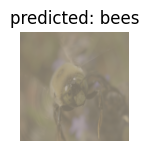

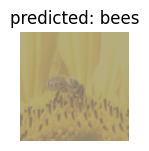

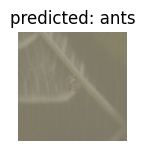

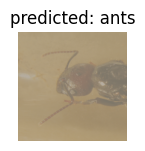

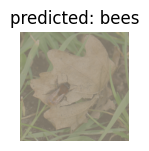

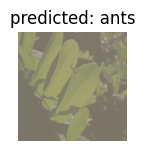

In [31]:
visualize_model(model2)
plt.ioff()
plt.show()